In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import norm 
from scipy import stats
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek
from sklearn.utils import shuffle

path=r"F:\Diverse\statistics\Python_data_analysis\首届（2017）中国工业大数据创新竞赛\叶片结冰预测"
os.chdir(path)
%matplotlib inline

### 1.导入数据集
 - 建立多项式特征
 - 优选的随机抽样训练集
 - Easyensemble抽样训练集

In [2]:
#创造多项式特征
from sklearn.preprocessing import PolynomialFeatures 

def polyfeature(x_resample):    
    x_resample_poly=PolynomialFeatures().fit_transform(x_resample)
    poly_feature=PolynomialFeatures().fit(x_resample).get_feature_names(input_features=x_resample.columns)
    x_resample_poly=pd.DataFrame(x_resample_poly,columns=poly_feature)
    return x_resample_poly

In [4]:
from sklearn.model_selection import train_test_split

data1=pd.read_csv("20170904_train_data_all.csv")
x_resample=data1.iloc[:,:-1]
y_resample=data1.results

x_resample_poly=polyfeature(x_resample)

#根据需求调整特征
feature_rank=pd.read_csv("feature_rank.csv",index_col=0)
feature=feature_rank[feature_rank.f_index>=3].index
x_resample_poly=x_resample_poly[feature]
#x_resample_poly.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)

#特征调整后的训练集
X_train,X_test,y_train,y_test=train_test_split(x_resample_poly,y_resample,random_state=42,train_size=0.75)

#sum(negative)/sum(positive)
ratio=(np.count_nonzero(y_train==1)/np.count_nonzero(y_train==0))

print(X_train.shape,"\n",feature,"\nratio: ",ratio)

(51795, 13) 
 Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object', name='feature_name') 
ratio:  1.003055147343182


In [5]:
data2=pd.read_csv("Easyensemble_train.csv")
x_ensemble=data2.iloc[:,:-1]
y_ensemble=data2.results
X_train_ensemble,X_test_ensemble,y_train_ensemble,y_test_ensemble=train_test_split(x_ensemble,y_ensemble,train_size=0.75,random_state=42)

ratio_ensemble=(np.count_nonzero(y_train_ensemble==1)/np.count_nonzero(y_train_ensemble==0))
print(X_train_ensemble.shape,"\n",feature,"\nratio_ensemble: ",ratio_ensemble)

(51795, 13) 
 Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object', name='feature_name') 
ratio_ensemble:  1.0056923791821561


### 2.定义模型选择标准
 - 建立得分器
 - 建立参数搜索函数
 - 建立学习曲线函数
 - 建立交叉验证曲线函数
 - 建立ROC_AUC判分函数

In [6]:
from sklearn import metrics   #Additional scklearn functions
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.metrics import make_scorer

def precision_tn(actuals,predictions):
    tn, fp, fn, tp = metrics.confusion_matrix(actuals,predictions).ravel()
    #score=tn/(fp+tn)*100
    normal=tp+fn
    fault=fp+tn
    score=(1-0.5*fn/normal-0.5*fp/fault)*100
    return score

#判分方法
scoring=make_scorer(precision_tn,greater_is_better=True)
#scoring=make_scorer(f1_score,greater_is_better=True,average="weighted")
#scoring_=make_scorer(recall_score,greater_is_better=True,average="weighted")

In [7]:
#模型参数搜索

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import learning_curve 
from sklearn.model_selection import validation_curve 
from sklearn.metrics import roc_curve,roc_auc_score

def get_model(estimator,parameters,X_train,y_train,scoring,iid=False):
    model=GridSearchCV(estimator,param_grid=parameters,scoring=scoring,iid=iid,cv=3)
    model.fit(X_train,y_train)
    return model

#样本学习曲线
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=5,
                       n_jobs=1,train_sizes=np.linspace(.1,1.0,5),scoring="precision"):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    train_sizes,train_scores,test_scores=learning_curve(estimator,X,y,cv=cv,scoring=scoring,
                                                       n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,
                    train_scores_mean+train_scores_std,alpha=0.2,color="r")
    
    plt.fill_between(train_sizes,test_scores_mean-test_scores_std,
                    test_scores_mean+test_scores_std,alpha=0.1,color="g")
    
    plt.plot(train_sizes,train_scores_mean,"o-",color="r",label="Training score")
    plt.plot(train_sizes,test_scores_mean,"o-",color="g",label="Cross_validation score")
    
    plt.legend(loc="best")
    
    return plt

#参数验证曲线
def plot_validation_curve(estimator,title,X,y,ylim=None,cv=5,param_name="parameter",
                       n_jobs=1,param_range=np.linspace(.1,1.0,5),scoring=scoring):
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(param_name)
    plt.ylabel(scoring)
    train_scores,test_scores=validation_curve(estimator,X,y,cv=cv,scoring=scoring,
                                              n_jobs=n_jobs,param_name=param_name,
                                              param_range=param_range)
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    
    plt.grid()
    
    plt.fill_between(param_range,train_scores_mean-train_scores_std,
                    train_scores_mean+train_scores_std,alpha=0.2,color="r")
    
    plt.fill_between(param_range,test_scores_mean-test_scores_std,
                    test_scores_mean+test_scores_std,alpha=0.1,color="g")
    
    plt.plot(param_range,train_scores_mean,"o-",color="r",label="Training score")
    plt.plot(param_range,test_scores_mean,"o-",color="g",label="Cross_validation score")
    
    plt.legend(loc="best")
    
    return plt

#ROC曲线
#意义：在比较不同的分类模型时，可以将每个模型的ROC曲线都画出来，比较曲线下面积做为模型优劣的指标。
#参考https://zh.wikipedia.org/wiki/ROC%E6%9B%B2%E7%BA%BF
#计算原理参考http://blog.csdn.net/zdy0_2004/article/details/44948511
def plot_roc_curve(estimator,X,y,ylim=None):
    #计算fpr,tpr,auc  
    try:
        y_score=estimator.decision_function(X)
    except:
        y_score=estimator.predict_proba(X)[:,1]
    fpr,tpr,_=roc_curve(y,y_score)
    auc_score=roc_auc_score(y,y_score)
    #绘图
    plt.figure(figsize=(10,6))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label="luck")
    plt.plot(fpr,tpr,color="darkorange",lw=2,label="Roc curve (area=%0.2f)" % auc_score)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")   
    plt.grid()
    
    return plt



### 3.XGBoost模型训练
 - 建立判分函数
 - 建立XGBoost模型调参函数
 - XGBoost函数

In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
def score_func(actuals,predictions):
    #tn, fp, fn, tp 
    tp,fn,fp,tn = metrics.confusion_matrix(actuals,predictions).ravel()
    normal=tp+fn
    fault=fp+tn
    score=(1-0.5*fn/normal-0.5*fp/fault)*100
    score_tp=tp/(tp+fn)*100
    score_tn=tn/(fp+tn)*100
    print("fn: ",fn,"fp: ",fp,"tn: ",tn,"tp: ",tp)
    return [score,score_tp,score_tn]
    

In [10]:
#parameter tuning function
def modelfit(alg, x_train, y_train,x_test,y_test,y=y_ensemble,flag=True,useTrainCV=True, cv_folds=5, early_stopping_rounds=20,scoring="auc"):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=scoring, early_stopping_rounds=early_stopping_rounds, show_stdv=False)
        if flag:
            alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train,eval_metric=scoring)
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_test)
    dtrain_predprob = alg.predict_proba(x_test)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Score : " ,score_func(y_test, dtrain_predictions))
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_test, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_test, dtrain_predprob))
    
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [11]:
data=pd.read_csv(r"train\train.csv")
results=pd.read_csv(r"train\results.csv")
data.drop(["pitch_speed","acc","pitch_ng5_DC"],axis=1,inplace=True)
#data.drop(["generator_speed","yaw_speed","pitch_speed","pitch_ng5_tmp","pitch_ng5_DC","acc","difference_wind_direction"],axis=1,inplace=True)
data=polyfeature(data)[feature]
#9个特征
#data.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)

print(data.shape,results.shape)

(553715, 13) (553715, 1)


In [11]:
#使用Easyensemble抽样样本
xgb_final = XGBClassifier(
 learning_rate =0.0001,
 n_estimators=20,
 max_depth=12,
 min_child_weight=10,
 gamma=0.4,
 subsample=0.5,
 colsample_bytree=0.7,
 reg_alpha=140,#225,
 reg_lambda=20,#50,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=ratio_ensemble*0.8,
 seed=27)

gbm = xgb_final.fit(X_train_ensemble, y_train_ensemble)
#gbm = xgb_final.fit(x_ensemble, y_ensemble)
print(gbm)

print(f1_score(y_test_ensemble,gbm.predict(X_test_ensemble)))
print(recall_score(y_test_ensemble,gbm.predict(X_test_ensemble)))
print(precision_score(y_test_ensemble,gbm.predict(X_test_ensemble)))
print(score_func(y_test_ensemble,gbm.predict(X_test_ensemble)))
print(score_func(results,gbm.predict(data)))
#plot_learning_curve(gbm,"XGBoost",x_ensemble,y_ensemble)
#plot_validation_curve(gbm,"XGBoost",x_resample,y_resample,cv=4,param_name="n_estimators",param_range=np.linspace(500,1000,6,dtype=np.int32))
#plot_roc_curve(gbm,X_test,y_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.4, learning_rate=0.0001, max_delta_step=0, max_depth=12,
       min_child_weight=10, missing=None, n_estimators=20, nthread=4,
       objective='binary:logistic', reg_alpha=140, reg_lambda=20,
       scale_pos_weight=0.804553903345725, seed=27, silent=True,
       subsample=0.5)
0.903514897579
0.906998481131
0.900057971014
fn:  862 fp:  796 tn:  7763 tp:  7844
[90.399315280991573, 90.098782448885828, 90.699848113097332]
fn:  49896 fp:  3224 tn:  31306 tp:  469289
[90.526372142312724, 90.389552856881465, 90.663191427743996]


<module 'matplotlib.pylab' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pylab.py'>

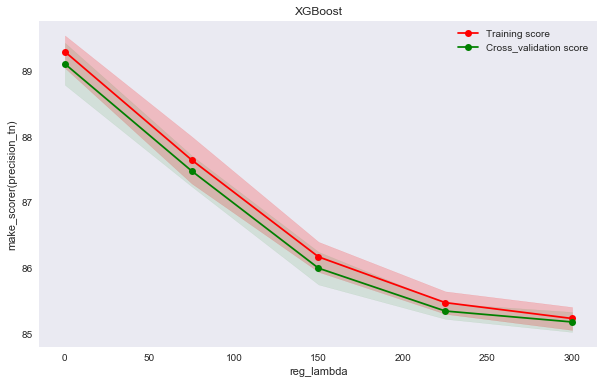

In [12]:
plot_validation_curve(gbm,"XGBoost",x_resample_poly,y_resample,cv=3,param_name="reg_lambda",param_range=np.linspace(0.001,300,5,dtype=np.int32))

<module 'matplotlib.pylab' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pylab.py'>

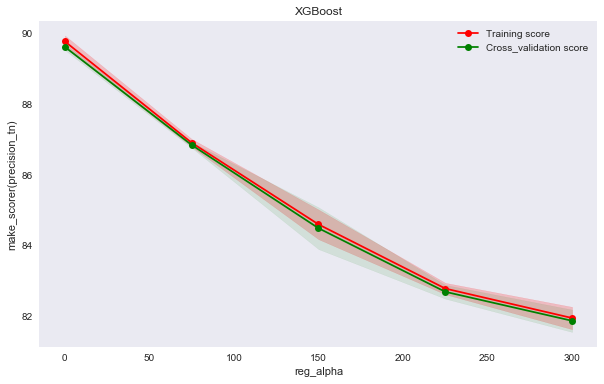

In [13]:
plot_validation_curve(gbm,"XGBoost",x_resample_poly,y_resample,cv=3,param_name="reg_alpha",param_range=np.linspace(0.001,300,5,dtype=np.int32))


Model Report
fn:  686 fp:  2001 tn:  6558 tp:  8020
Score :  [84.370738673764762, 92.120376751665518, 76.621100595863993]
Accuracy : 0.8444
AUC Score (Train): 0.938085


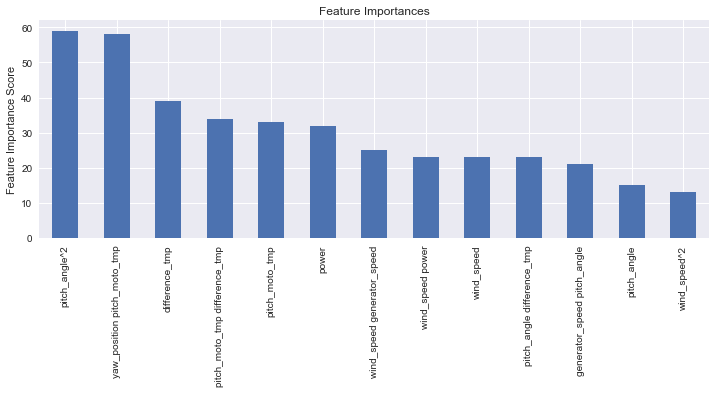

In [14]:
modelfit(xgb_final, X_train_ensemble,y_train_ensemble,X_test_ensemble,y_test_ensemble,y=y_ensemble,flag=True)

### 4. 预测测试集
 - 导入测试集
 - 封装测试结果

In [12]:
#导入测试集
test_=pd.read_csv(r"test\08\08_data.csv")
time=test_.time
print(test_.shape)

(202328, 28)


In [13]:
def test_preprocess(test_=test_,feature_numbers=13,features=feature):
    #将成组的变量转化为均值，约简为该属性的特征
    test_["pitch_angle"]=test_[["pitch1_angle","pitch2_angle","pitch3_angle"]].T.mean()
    test_["pitch_speed"]=test_[["pitch1_speed","pitch2_speed","pitch3_speed"]].T.mean()
    test_["pitch_moto_tmp"]=test_[["pitch1_moto_tmp","pitch2_moto_tmp","pitch3_moto_tmp"]].T.mean()
    test_["pitch_ng5_tmp"]=test_[["pitch1_ng5_tmp","pitch2_ng5_tmp","pitch3_ng5_tmp"]].T.mean()
    test_["pitch_ng5_DC"]=test_[["pitch1_ng5_DC","pitch2_ng5_DC","pitch3_ng5_DC"]].T.mean()
    test_["acc"]=np.sqrt((test_.acc_x.values)**2+(test_.acc_y.values)**2)
    
    #丢弃多余特征
    test_=test_.drop(["pitch1_angle","pitch2_angle","pitch3_angle","pitch1_speed","pitch2_speed","pitch3_speed","pitch1_moto_tmp","pitch2_moto_tmp","pitch3_moto_tmp","pitch1_ng5_tmp","pitch2_ng5_tmp","pitch3_ng5_tmp","pitch1_ng5_DC","pitch2_ng5_DC","pitch3_ng5_DC"],axis=1)
    test_=test_.drop(["group","time","acc_x","acc_y"],axis=1)
    
    #生成新特征
    #考虑偏航系统对风角跟风向角有关，做差
    #考虑环境温度与机舱温度差
    #偏航速度受偏航系统限制，变化不大，舍弃
    test_["difference_tmp"]=test_.int_tmp-test_.environment_tmp
    test_["difference_wind_direction"]=test_.wind_direction_mean-test_.wind_direction
    test_.drop(["yaw_speed","int_tmp","environment_tmp","wind_direction_mean","wind_direction"],axis=1,inplace=True)
    
    test_.drop(["pitch_speed","acc","pitch_ng5_DC"],axis=1,inplace=True)
    if feature_numbers==13:
        test_=polyfeature(test_)[features]
    else:
        test_=polyfeature(test_)[features]
        test_.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)
    #离散化重要变量
    #binsfeature(test_,bins_method=1)
    print(test_.shape)
    return test_

In [14]:
test_=test_preprocess(test_,feature_numbers=13)
test_.columns

(202328, 13)


Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object')

test_=pca.transform(test_)
test_.shape

In [15]:
#预测
def predict_func(estimator=None,filename=r"test1_08_results",test=test_):
    test_predict=estimator.predict(test)
    print(np.count_nonzero(test_predict[test_predict==1]))#统计事故次数
    
    # 整理预测结果集合
    test_time=pd.merge(pd.DataFrame(time),pd.DataFrame(test_predict,columns=["state"]),left_index=True,right_index=True)
    test_time=test_time.drop(test_time[test_time.state==0].index,axis=0)#丢弃正常状况行
    
    #剔除连续时间，仅保存事故时间段
    difference=test_time.time[1:].values-test_time.time[:-1].values #通过时间差判断是否存在连续事故时间段   
    dif_index=np.where(difference!=1)
    test_time.index=np.arange(test_time.shape[0])
    start=test_time.time[dif_index[0]+1]
    end=test_time.time[dif_index[0]]
    #补充start头部
    if difference[0]==1:
        start=np.insert(start.values,0,test_time.time[0])
    else:
        start=np.insert(start.values,0,end.values[0])
        
    #补充end尾部
    if difference[-1]==1:
        end=np.append(end.values,test_time.time.values[-1])
    else:
        end=np.append(end.values,start[-1])
        
    results={"startTime":start,"endTime":end}
    output=pd.DataFrame(results,columns=["startTime","endTime"])
    
    output.to_csv(filename+r".csv",index=False)
    
    return test_predict

### 5.利用train_15训练集，查看模型准确度

In [16]:
#data=pd.read_csv(r"train\train_15.csv")
#results=pd.read_csv(r"train\train_15_results.csv")
#data.drop(["pitch_speed","acc","pitch_ng5_DC"],axis=1,inplace=True)
data=pd.read_csv(r"train\train.csv")
results=pd.read_csv(r"train\results.csv")
data.drop(["pitch_speed","acc","pitch_ng5_DC"],axis=1,inplace=True)
#data.drop(["generator_speed","yaw_speed","pitch_speed","pitch_ng5_tmp","pitch_ng5_DC","acc","difference_wind_direction"],axis=1,inplace=True)
data=polyfeature(data)[feature]
#9个特征
#data.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)

print(data.shape,results.shape)

from imblearn.ensemble import EasyEnsemble
ee=EasyEnsemble()
x_rem,y_rem=ee.fit_sample(data,results)

x_rem.shape

(553715, 13) (553715, 1)


D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(10, 69060, 13)

In [18]:
from sklearn.model_selection import train_test_split

data1=pd.read_csv("20170904_train_data_all.csv")
x_resample=data1.iloc[:,:-1]
y_resample=data1.results

x_resample_poly=polyfeature(x_resample)

#根据需求调整特征
feature_rank=pd.read_csv("feature_rank.csv",index_col=0)
feature=feature_rank[feature_rank.f_index>=3].index
x_resample_poly=x_resample_poly[feature]
#x_resample_poly.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)

#特征调整后的训练集
X_train,X_test,y_train,y_test=train_test_split(x_resample_poly,y_resample,random_state=42,train_size=0.75)

#sum(negative)/sum(positive)
ratio=(np.count_nonzero(y_train==1)/np.count_nonzero(y_train==0))

print(X_train.shape,"\n",feature,"\nratio: ",ratio)

(51795, 13) 
 Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object', name='feature_name') 
ratio:  1.003055147343182


In [19]:
data2=pd.read_csv("Easyensemble_train.csv")
#data2.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)
x_ensemble=data2.iloc[:,:-1]
y_ensemble=data2.results
X_train_ensemble,X_test_ensemble,y_train_ensemble,y_test_ensemble=train_test_split(x_ensemble,y_ensemble,train_size=0.75,random_state=42)

ratio_ensemble=(np.count_nonzero(y_train_ensemble==1)/np.count_nonzero(y_train_ensemble==0))
print(X_train_ensemble.shape,"\n",feature,"\nratio_ensemble: ",ratio_ensemble)

(51795, 13) 
 Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object', name='feature_name') 
ratio_ensemble:  1.0056923791821561


In [70]:
data3=pd.read_csv(r"trainensemble\train_15_ensemble.csv")
#data3.drop(["pitch_angle","wind_speed power","generator_speed pitch_angle","wind_speed^2"],axis=1,inplace=True)
x_ensemble3=data3.iloc[:,:-1]
y_ensemble3=data3.results
X_train_ensemble3,X_test_ensemble3,y_train_ensemble3,y_test_ensemble3=train_test_split(x_ensemble3,y_ensemble3,train_size=0.75,random_state=42)

ratio_ensemble3=(np.count_nonzero(y_train_ensemble3==1)/np.count_nonzero(y_train_ensemble3==0))
print(X_train_ensemble3.shape,"\n",feature,"\nratio_ensemble3: ",ratio_ensemble3)

(35838, 13) 
 Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object', name='feature_name') 
ratio_ensemble3:  1.0010050251256282


In [87]:
#使用Easyensemble抽样样本
xgb_final = XGBClassifier(
 learning_rate =0.0001,
 n_estimators=100,
 max_depth=6,
 min_child_weight=10,
 gamma=0.4,
 subsample=0.5,
 colsample_bytree=0.7,
 reg_alpha=50,
 reg_lambda=20,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=ratio_ensemble3,
 seed=27)

gbm = xgb_final.fit(X_train_ensemble3, y_train_ensemble3)
#gbm = xgb_final.fit(x_ensemble, y_ensemble)
print(gbm)

print(f1_score(y_test_ensemble3,gbm.predict(X_test_ensemble3)))
print(recall_score(y_test_ensemble3,gbm.predict(X_test_ensemble3)))
print(precision_score(y_test_ensemble3,gbm.predict(X_test_ensemble3)))
print(score_func(y_test_ensemble3,gbm.predict(X_test_ensemble3)))
print(score_func(results,gbm.predict(data)))
#plot_learning_curve(gbm,"XGBoost",x_ensemble,y_ensemble)
#plot_validation_curve(gbm,"XGBoost",x_resample,y_resample,cv=4,param_name="n_estimators",param_range=np.linspace(500,1000,6,dtype=np.int32))
#plot_roc_curve(gbm,X_test,y_test)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.4, learning_rate=0.0001, max_delta_step=0, max_depth=6,
       min_child_weight=10, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=50, reg_lambda=20,
       scale_pos_weight=1.0010050251256282, seed=27, silent=True,
       subsample=0.5)
0.913437219548
0.938631790744
0.889559828381
fn:  695 fp:  366 tn:  5598 tp:  5287
[91.122495588711132, 88.381812102975601, 93.863179074446677]
fn:  71549 fp:  4266 tn:  30264 tp:  447636
[86.9322517254475, 86.218977821007925, 87.645525629887061]


<module 'matplotlib.pylab' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pylab.py'>

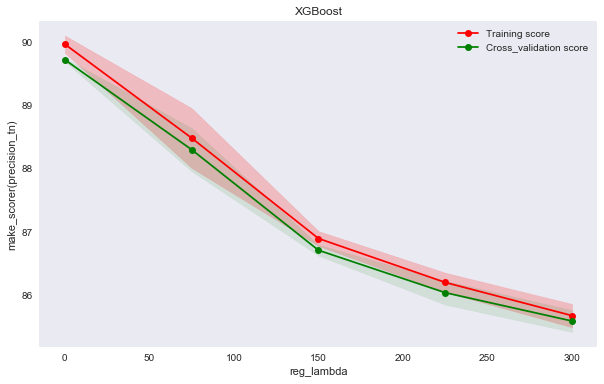

In [23]:
plot_validation_curve(gbm,"XGBoost",x_resample_poly,y_resample,cv=3,param_name="reg_lambda",param_range=np.linspace(0.001,300,5,dtype=np.int32))

<module 'matplotlib.pylab' from 'D:\\Anaconda3\\lib\\site-packages\\matplotlib\\pylab.py'>

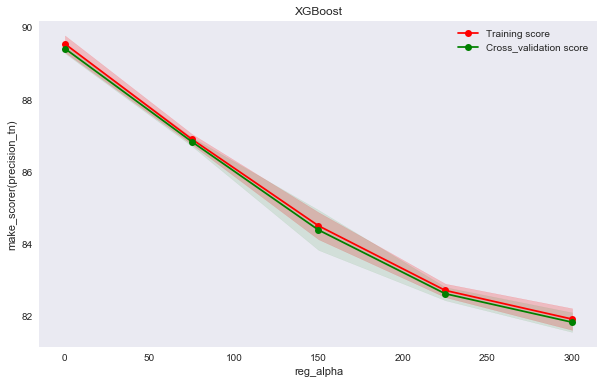

In [24]:
plot_validation_curve(gbm,"XGBoost",x_resample_poly,y_resample,cv=3,param_name="reg_alpha",param_range=np.linspace(0.001,300,5,dtype=np.int32))


Model Report
fn:  1019 fp:  800 tn:  7759 tp:  7687
Score :  [89.474271060830517, 88.295428440156215, 90.653113681504848]
Accuracy : 0.8946
AUC Score (Train): 0.952893


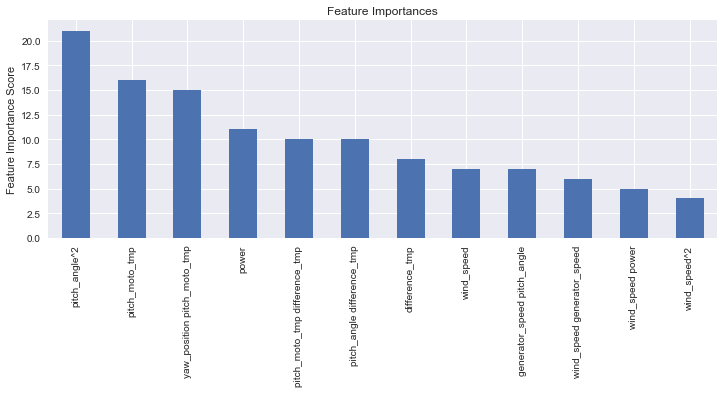

In [88]:
modelfit(xgb_final, X_train_ensemble,y_train_ensemble,X_test_ensemble,y_test_ensemble,flag=True)

In [89]:
xgb_final.n_estimators

4

for i in range(0,x_rem.shape[0]):
    x_=pd.DataFrame(x_rem[i],columns=data.columns)
    print(score_func(y_rem[i],xgb_final.predict(x_)))

In [90]:
test_predict=predict_func(estimator=gbm,filename="random-XGBoost-combination-0.0001-ratio-0.925",test=test_)

26786


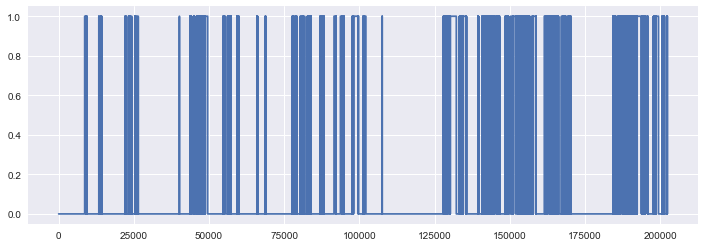

In [42]:
plt.step(x=np.arange(1,test_predict.shape[0]+1),y=test_predict)

- 在这篇ipython中，train-set融合了train_21和train_15
- 因仅含两个数据集，测试集无奈选择train-set
- 得分结果可知，各模型都可以取得较高分数
- 为排除模型过度学习train-set，可采取的方法有：
  1. 降低样本学习权重learning_rate
  2. 减小树深度max_depth
  3. 减小最小子树权重min_child_weight
  4. 弱化子样本采样率subsample
  5. 设置合理的不平衡样本权重scale_pos_weight

### 6.预测最终数据集

In [68]:
test10=pd.read_csv(r"Test_final\10\10_data.csv")
test14=pd.read_csv(r"Test_final\14\14_data.csv")

test10["group"]=0
test14["group"]=0

test10=test_preprocess(test10,feature_numbers=13)
test14=test_preprocess(test14,feature_numbers=13)

(174301, 13)
(163732, 13)


In [91]:
test10_predict=predict_func(estimator=gbm,filename="test2_10_results.csv",test=test10)
test14_predict=predict_func(estimator=gbm,filename="test2_14_results.csv",test=test14)

41904
29594


In [31]:
test10.columns

Index(['wind_speed', 'pitch_moto_tmp difference_tmp', 'pitch_angle^2',
       'difference_tmp', 'pitch_moto_tmp', 'pitch_angle', 'wind_speed power',
       'power', 'wind_speed generator_speed', 'pitch_angle difference_tmp',
       'yaw_position pitch_moto_tmp', 'generator_speed pitch_angle',
       'wind_speed^2'],
      dtype='object')

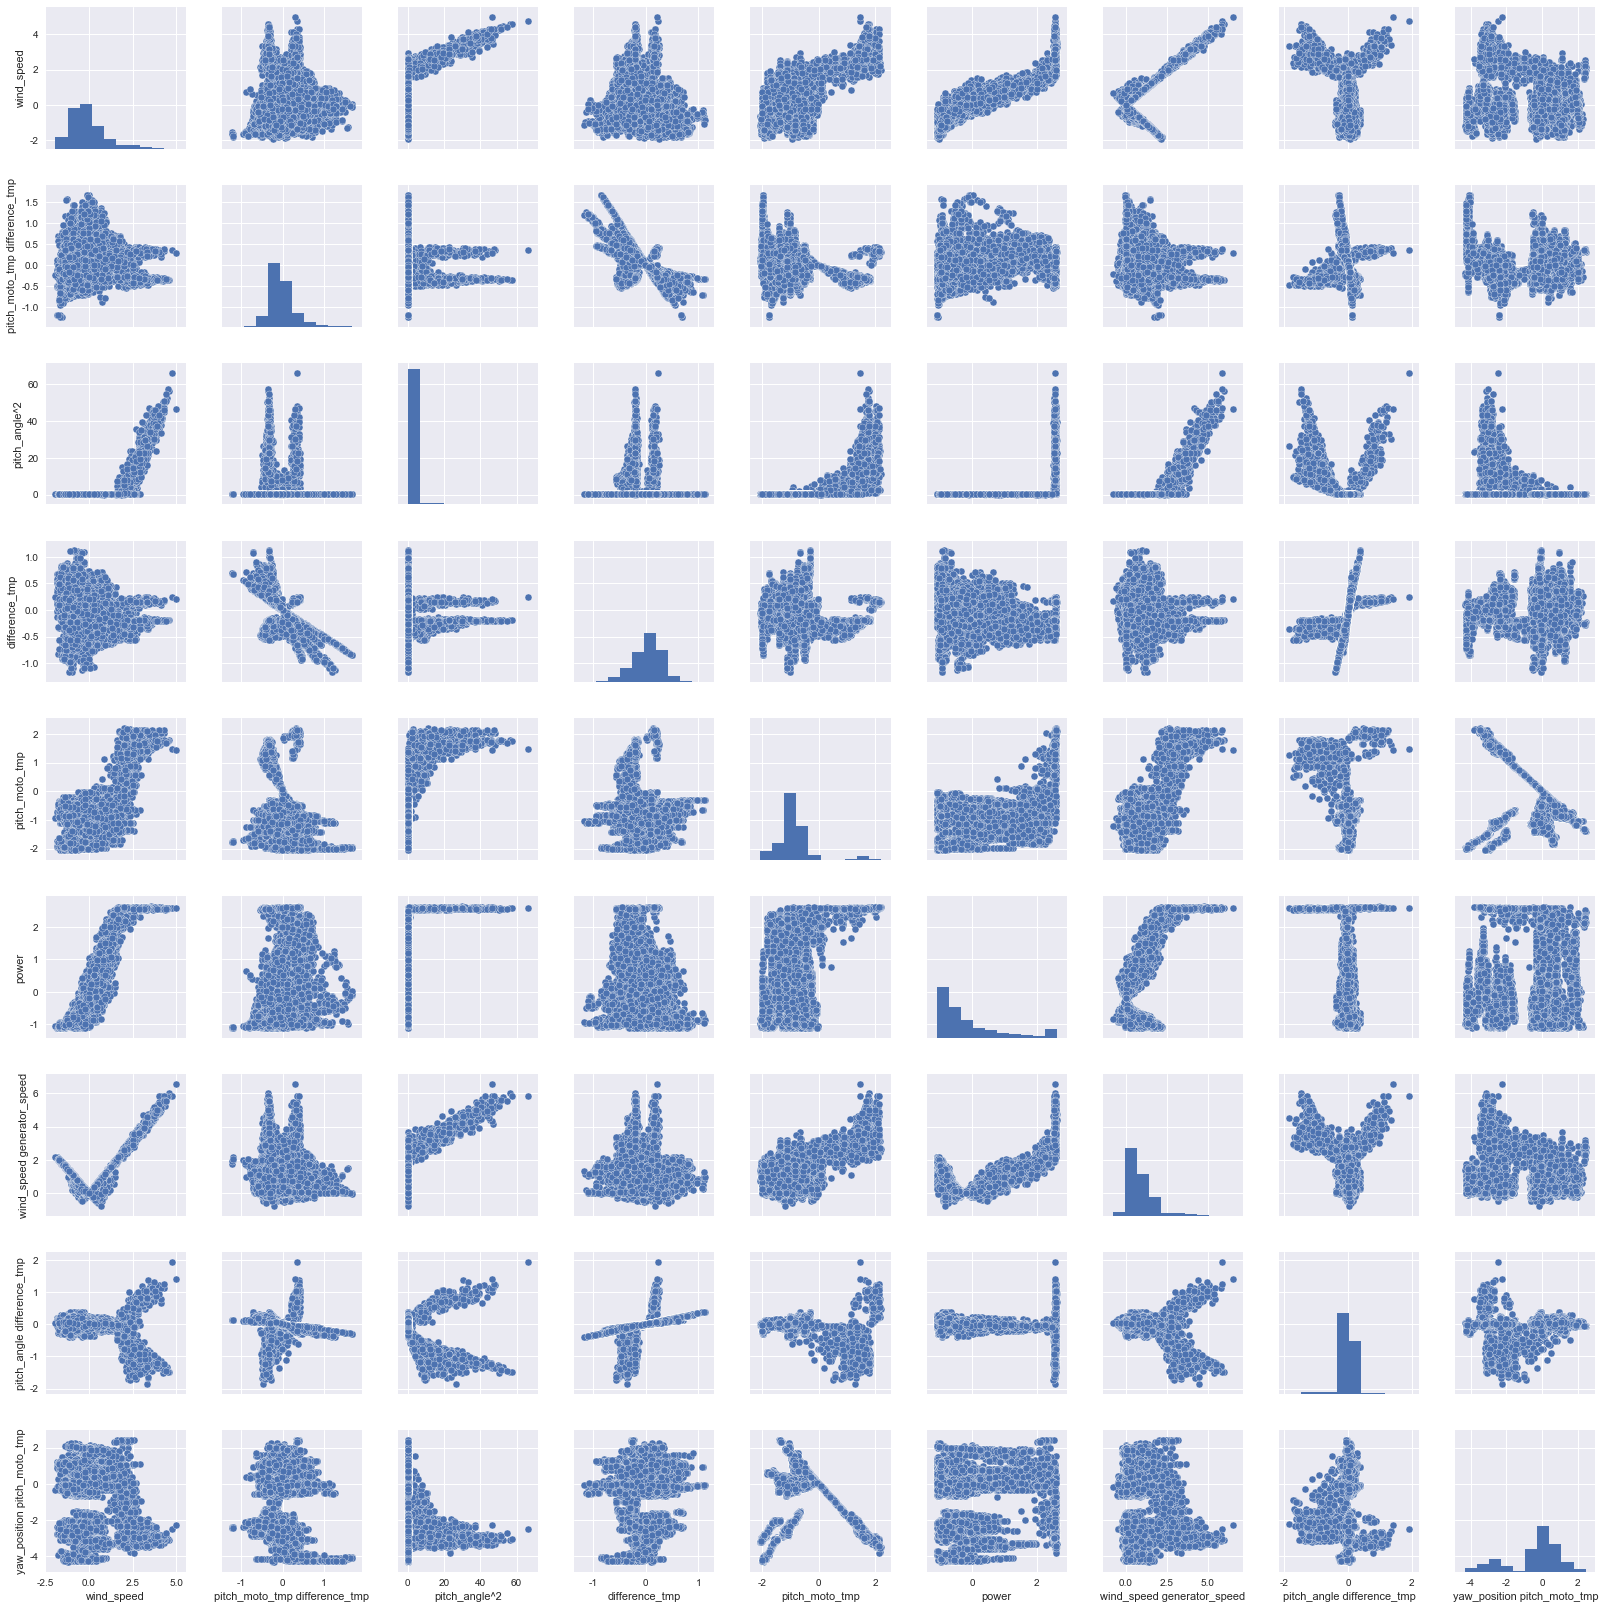

In [33]:
sns.pairplot(test10.sample(frac=0.1))

In [32]:
test14.shape

(163732, 13)